# Machine Learning and Comic Book Characters
Ariana Olson, Emma Price

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import thinkstats2
import thinkplot

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.models
import keras.layers

import pickle

Using TensorFlow backend.


## Explore the data

In [2]:
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)
    
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)
    
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)

In [3]:
both_df = pd.read_hdf('both_df.hdf5', key='both')
marvel_df = pd.read_hdf('marvel_df.hdf5', key='marvel')
dc_df = pd.read_hdf('dc_df.hdf5', key='dc')

In [4]:
both_df.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,YEAR,dcmar
0,1422,1618,11996,4.0,1.0,4.0,2.0,4.0,3,1.0,3093.0,1939.0,1
1,23387,15961,17405,4.0,1.0,4.0,2.0,4.0,3,1.0,2496.0,1986.0,1
2,1458,6545,13886,4.0,1.0,5.0,6.0,4.0,3,1.0,1565.0,1959.0,1
3,1659,7930,14402,3.0,1.0,5.0,25.0,4.0,3,1.0,1316.0,1987.0,1
4,1576,14024,16678,4.0,1.0,4.0,2.0,4.0,3,1.0,1237.0,1940.0,1


In [5]:
both_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18295 entries, 0 to 11398
Data columns (total 13 columns):
page_id        18295 non-null int64
name           18295 non-null int64
urlslug        18295 non-null int64
ID             14061 non-null float64
ALIGN          16045 non-null float64
EYE            8496 non-null float64
HAIR           13611 non-null float64
SEX            17728 non-null float64
GSM            18295 non-null int64
ALIVE          18291 non-null float64
APPEARANCES    17939 non-null float64
YEAR           17851 non-null float64
dcmar          18295 non-null int64
dtypes: float64(8), int64(5)
memory usage: 2.0 MB


In [6]:
both_df.describe()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,YEAR,dcmar
count,18295.000000,18295.000000,18295.000000,14061.000000,16045.000000,8496.000000,13611.000000,17728.000000,18295.000000,18291.000000,17939.000000,17851.000000,18295.000000
mean,219154.987483,9147.000000,9147.000000,3.409004,0.650545,7.728696,6.942840,3.177177,2.989505,0.754633,22.906517,1985.812447,0.376934
std,213972.005972,5281.455923,5281.455923,0.663455,0.695984,6.475668,6.904425,1.340334,0.146380,0.430316,103.055100,19.288066,0.484631
min,1025.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1935.000000,0.000000
25%,21599.500000,4573.500000,4573.500000,3.000000,0.000000,4.000000,2.000000,1.000000,3.000000,1.000000,2.000000,1975.000000,0.000000
50%,154770.000000,9147.000000,9147.000000,4.000000,1.000000,5.000000,3.000000,4.000000,3.000000,1.000000,5.000000,1990.000000,0.000000
75%,348820.000000,13720.500000,13720.500000,4.000000,1.000000,8.000000,10.000000,4.000000,3.000000,1.000000,13.000000,2000.000000,1.000000
max,754840.000000,18294.000000,18294.000000,4.000000,3.000000,25.000000,26.000000,5.000000,6.000000,1.000000,4043.000000,2013.000000,1.000000


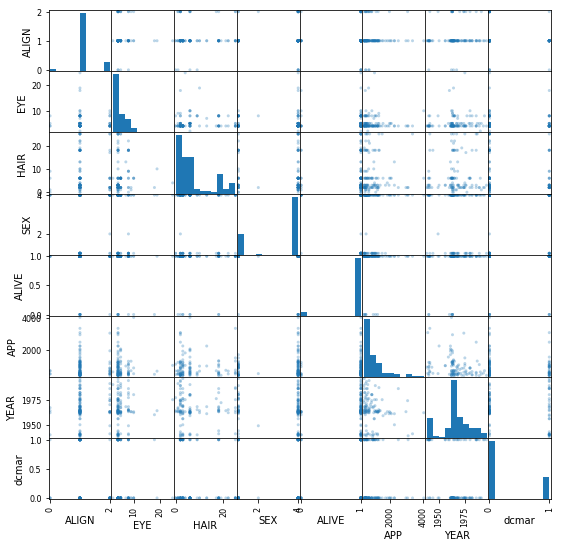

In [7]:
X = both_df.drop(['ID', 'page_id', 'name','urlslug', 'GSM'], axis=1).values

df =  pd.DataFrame(X, columns = ['ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','YEAR', 'dcmar'])
df = df[df['APP']>400]


_ = pd.plotting.scatter_matrix(df.dropna(),alpha = 0.3, figsize=[9,9])

/home/ariana/.local/lib/python3.6/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  ax.set_xlim(boundaries_list[j])
/home/ariana/.local/lib/python3.6/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  ax.set_ylim(boundaries_list[i])
/home/ariana/.local/lib/python3.6/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  ax.set_xlim(boundaries_list[i])


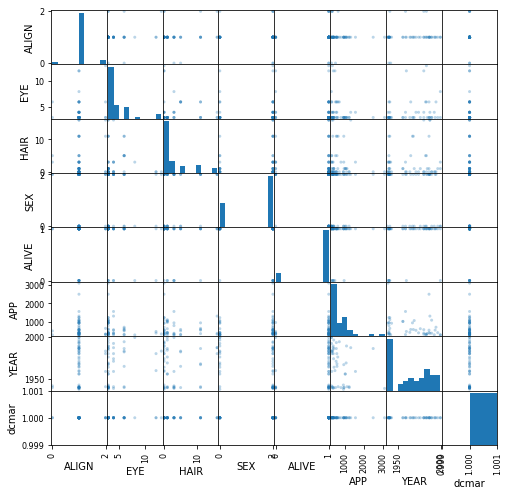

In [8]:
X = dc_df.drop(['ID', 'page_id', 'name','urlslug', 'GSM'], axis=1).values

df =  pd.DataFrame(X, columns = ['ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','YEAR', 'dcmar'])
df = df[df['APP']>300]


_ = pd.plotting.scatter_matrix(df.dropna(),alpha = 0.3, figsize=[8,8])

/home/ariana/.local/lib/python3.6/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/home/ariana/.local/lib/python3.6/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
/home/ariana/.local/lib/python3.6/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[i])


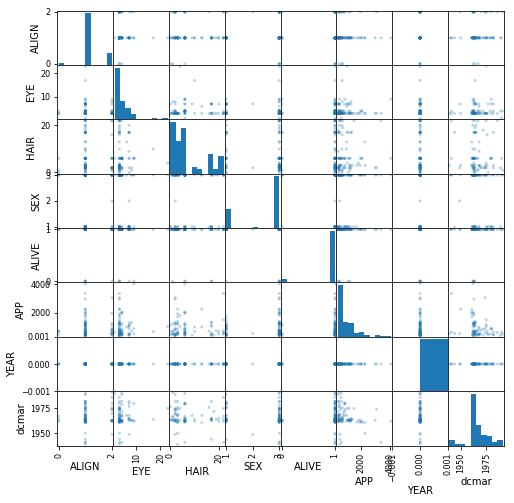

In [9]:
X = marvel_df.drop(['ID', 'page_id', 'name','urlslug', 'GSM'], axis=1).values

df =  pd.DataFrame(X, columns = ['ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','YEAR', 'dcmar'])
df = df[df['APP']>400]


_ = pd.plotting.scatter_matrix(df.dropna(),alpha = 0.3, figsize=[8,8])

In [10]:
y = both_df.dropna()['YEAR'].values
X = both_df.dropna().drop(['YEAR', 'page_id', 'name','urlslug','GSM'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

linreg = linear_model.LinearRegression()

linreg.fit(X_train,y_train)

y_pred = linreg.predict(X_test)

print("R^2: {}".format(linreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.10315077743642553
Root Mean Squared Error: 17.17718037872186


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.35760864 0.1846608  0.3569307  ... 0.42632828 0.31433741 0.39322988]
R^2: 0.6315524193548387
Root Mean Squared Error: 0.6069988308433232
0.5847160778991418
[[1244    2]
 [ 729    9]]


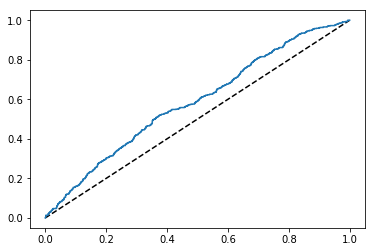

In [16]:
clean_df = both_df.drop(['page_id','name','urlslug', 'ID', 'GSM'], axis=1).dropna()

y = clean_df['dcmar'].dropna().values
X = clean_df.drop('dcmar', axis=1).dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
y_pred.mean()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred.mean()
y_pred_prob = logreg.predict_proba(X_test)[:,1]

print(y_pred_prob)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

In [17]:
clean_df = both_df.drop(['page_id','name','urlslug', 'ID', 'GSM'], axis=1).dropna()

y = clean_df['dcmar'].dropna().values
X = clean_df.drop('dcmar', axis=1).dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

ridge = linear_model.RidgeClassifier(normalize=True)

ridge.fit(X_train,y_train)

y_pred = ridge.predict(X_test)
                 
print("R^2: {}".format(ridge.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.6280241935483871
Root Mean Squared Error: 0.6098981935139772


In [22]:
clean_df = both_df.drop(['page_id','name','urlslug', 'ID', 'GSM'], axis=1).dropna()

y = clean_df['YEAR'].dropna().values
X = clean_df.drop('YEAR', axis=1).dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

ridge = linear_model.Ridge(normalize=True)

ridge.fit(X_train,y_train)

y_pred = ridge.predict(X_test)
                 
print("R^2: {}".format(ridge.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.0995352323334956
Root Mean Squared Error: 16.878224067531644


### Neural Network

In [46]:
clean_df = both_df.drop(['page_id','name','urlslug'], axis=1).dropna()

y = clean_df['YEAR'].dropna().values
X = clean_df.drop('YEAR', axis=1).dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=(X.shape[-1],)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Epoch 1/1
4141/4141 [==============================] - 1s 136us/step - loss: 3655607.2423
Epoch 1/1
4141/4141 [==============================] - 0s 45us/step - loss: 2456383.1428
Epoch 1/1
4141/4141 [==============================] - 0s 61us/step - loss: 1020487.4921
Epoch 1/1
4141/4141 [==============================] - 0s 60us/step - loss: 478604.8455
Epoch 1/1
4141/4141 [==============================] - 0s 42us/step - loss: 353673.1333
Epoch 1/1
4141/4141 [==============================] - 0s 45us/step - loss: 270608.5926
Epoch 1/1
4141/4141 [==============================] - 0s 40us/step - loss: 203576.1115
Epoch 1/1
4141/4141 [==============================] - 0s 58us/step - loss: 148639.2029
Epoch 1/1
4141/4141 [==============================] - 0s 84us/step - loss: 109051.0850
Epoch 1/1
4141/4141 [==============================] - 0s 117us/step - loss: 83379.4376 0s - loss: 9233


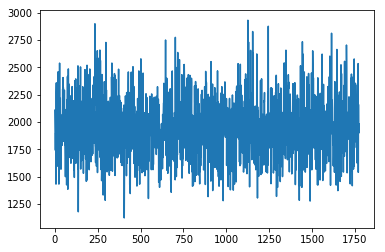

In [47]:
plt.plot(y_pred)